# Imports

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')

In [4]:
#xq = np.load('pred/feats_valid_pg'+str(pg)+'.npy')
#yq = np.load('pred/targs_cl_valid_pg'+str(pg)+'.npy')

In [5]:
xb.shape # nb-by-d

(72952, 512)

In [6]:
#xq.shape # nq-by-d (query vectors)

In [7]:
yb.shape

(72952,)

In [8]:
#yq.shape

# k-means

In [9]:
#k = sys.argv[1]
#ngpu = sys.argv[2]

In [10]:
#k, ngpu

In [11]:
# https://github.com/facebookresearch/faiss/blob/master/benchs/kmeans_mnist.py
def train_kmeans(x, k, ngpu):
    "Runs kmeans on one or several GPUs"
    d = x.shape[1]
    clus = faiss.Clustering(d, k)
    clus.verbose = True
    clus.niter = 20

    # otherwise the kmeans implementation sub-samples the training set
    clus.max_points_per_centroid = 10000000

    res = [faiss.StandardGpuResources() for i in range(ngpu)]

    flat_config = []
    for i in range(ngpu):
        cfg = faiss.GpuIndexFlatConfig()
        cfg.useFloat16 = False
        cfg.device = i
        flat_config.append(cfg)

    if ngpu == 1:
        index = faiss.GpuIndexFlatL2(res[0], d, flat_config[0])
    else:
        indexes = [faiss.GpuIndexFlatL2(res[i], d, flat_config[i])
                   for i in range(ngpu)]
        index = faiss.IndexReplicas()
        for sub_index in indexes:
            index.addIndex(sub_index)

    # perform the training
    clus.train(x, index)
    centroids = faiss.vector_float_to_array(clus.centroids)

    obj = faiss.vector_float_to_array(clus.obj)
    print("final objective: %.4g" % obj[-1])

    return centroids.reshape(k, d)

In [12]:
centr = train_kmeans(xb, 1108, 1)

final objective: 2.286e+08


In [13]:
centr.shape

(1108, 512)

In [14]:
type(centr)

numpy.ndarray

In [15]:
centr_norm = centr.copy()

In [16]:
centr_norm.max()

64.60149

In [17]:
faiss.normalize_L2(centr_norm)

In [18]:
centr_norm.max()

0.5773627

# Train

In [19]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 1080)

In [20]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [21]:
xb.max()

78.24533

In [22]:
faiss.normalize_L2(xb)

In [23]:
xb.max()

0.52523136

In [24]:
index.train(xb)

In [25]:
index.add_with_ids(xb, yb)

In [26]:
print(index.is_trained)
print(index.ntotal)

True
72952


## Centroids

In [27]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(centr_norm, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 535  535  535  535  535]
 [1035 1035 1035 1035 1035]
 [ 115  115  115  115  115]
 [ 626  626  290  626  626]
 [ 176  176  176  176  176]]
[[678]
 [576]
 [206]
 [162]
 [595]]
[[0.9985562  0.99829525 0.9977722  0.9977479  0.99760765]
 [0.9971198  0.99608827 0.99504936 0.99404794 0.99392414]
 [0.9928665  0.99245757 0.9916172  0.99160767 0.99143153]
 [0.96911764 0.9624497  0.9621809  0.9580128  0.94256103]
 [0.9975     0.9971553  0.9971123  0.9968343  0.99665344]]


In [28]:
I_train.shape, D_train.shape

((1108, 5), (1108, 5))

In [29]:
yb.max(), I_train.max()

(1107, 1107)

In [30]:
I_train

array([[ 535,  535,  535,  535,  535],
       [1035, 1035, 1035, 1035, 1035],
       [ 115,  115,  115,  115,  115],
       ...,
       [ 117,  117,  117,  117,  117],
       [ 581,  581,  581,  581,  581],
       [ 447,  447,  447,  447,  447]])

In [31]:
a, b = np.unique(I_train[:,0], return_counts=True)#.max()

In [32]:
# different sirna!
a.shape

(942,)

In [33]:
#I_train[:600,0]

In [34]:
#I_train[600:,0]

In [35]:
D_train

array([[0.9985562 , 0.99829525, 0.9977722 , 0.9977479 , 0.99760765],
       [0.9971198 , 0.99608827, 0.99504936, 0.99404794, 0.99392414],
       [0.9928665 , 0.99245757, 0.9916172 , 0.99160767, 0.99143153],
       ...,
       [0.99567133, 0.9956633 , 0.99543464, 0.9953333 , 0.9951372 ],
       [0.99438673, 0.99393183, 0.99383503, 0.99271584, 0.99260044],
       [0.9981047 , 0.9979181 , 0.9976832 , 0.99756116, 0.99728596]],
      dtype=float32)

#### New train

In [36]:
## setup
d = centr_norm.shape[1] # 512
nlist = int(4*np.sqrt(centr_norm.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 133)

In [37]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [38]:
centr_norm.max()

0.5773627

In [39]:
#faiss.normalize_L2(xb)

In [40]:
#xb.max()

In [41]:
index.train(centr_norm)

In [42]:
idx = np.ascontiguousarray(I_train[:,0])

In [43]:
index.add_with_ids(centr_norm, idx)

In [44]:
print(index.is_trained)
print(index.ntotal)

True
1108


## Train dataset

In [45]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 678  408  819  354  968]
 [ 576  576  596  596  682]
 [1003 1003 1003   44 1078]
 [ 162  112  557  316  945]
 [ 595  502  796  768  672]]
[[678]
 [576]
 [206]
 [162]
 [595]]
[[0.9911268  0.5294818  0.47621155 0.43784922 0.16409725]
 [0.9835273  0.9747804  0.812956   0.6751698  0.33846477]
 [0.39719912 0.3284387  0.28933752 0.20185933 0.14934011]
 [0.84280705 0.44492048 0.43855888 0.19788367 0.17668717]
 [0.99701184 0.6117185  0.38923442 0.2568937  0.22736512]]


In [46]:
I_train.shape, D_train.shape

((72952, 5), (72952, 5))

In [47]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [48]:
I_train[:,0].shape, yb.shape

((72952,), (72952,))

In [49]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

0.7305899769711591

In [50]:
I_train[:10,0], yb[:10]

(array([ 678,  576, 1003,  162,  595,   60,   49,  557,   40,  814]),
 array([678, 576, 206, 162, 595,  60,  35, 557,  40, 814]))

In [51]:
I_train[-10:,0], yb[-10:]

(array([1039,  660,  739,  584,  789,  845,  640,   97, 1052,  217]),
 array([1039,  660,  739,  584,  522,  845,  640,   97,  467,  217]))

### Train confusion matrix

In [22]:
#cm = confusion_matrix(I_train[:,0], yb)

In [23]:
#fig, ax = plt.subplots(figsize=(15,15))
#ax.matshow(cm, cmap='hot')

## Valid dataset

In [24]:
xq.max()

175.12431

In [25]:
faiss.normalize_L2(xq)

In [26]:
xq.max()

0.18379912

In [27]:
D_valid, I_valid = index.search(xq, k) # actual search

In [28]:
xq.shape, yq.shape

((3872, 512), (3872,))

In [29]:
I_valid.shape, D_valid.shape

((3872, 5), (3872, 5))

In [30]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[523 523 523 523 523]
 [798 798 798 798 798]
 [503 503 503 503 503]
 [505 505 505 505 505]
 [ 77 577  77 577  77]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.8896632  0.88688123 0.8868655  0.8808239  0.8804276 ]
 [0.7865324  0.77226573 0.76530886 0.7605244  0.7502717 ]
 [0.93739724 0.9361016  0.9245063  0.91801465 0.9136205 ]
 [0.8096291  0.80561084 0.8040674  0.8038868  0.80100644]
 [0.73833525 0.73712873 0.73280233 0.72592235 0.7237808 ]]


In [31]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 764  764  764  764  764]
 [1065 1065 1065 1065 1065]
 [ 301  301  301  301  301]
 [ 757  757  757  757  757]
 [ 831  831  831  831  831]]
[[ 764]
 [1065]
 [ 301]
 [ 757]
 [ 831]]
[[0.9985708  0.9976351  0.9973368  0.99691904 0.99681044]
 [0.72257435 0.7149862  0.71417344 0.706567   0.70287037]
 [0.9468025  0.9416362  0.9412949  0.94006944 0.9388693 ]
 [0.92361426 0.9224558  0.9221511  0.9208758  0.9195591 ]
 [0.97474384 0.971219   0.96412575 0.9612801  0.95688653]]


In [32]:
np.save('pred/preds_valid_pg'+str(pg)+'.npy', I_valid)

### Valid accuracy

In [33]:
I_valid[:,0]

array([523, 798, 503, ..., 301, 757, 831])

In [34]:
yq

array([352, 361, 503, ..., 301, 757, 831])

In [35]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

2492

In [36]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.643595041322314

In [37]:
valid_correct = np.equal(I_valid[:,0], yq)

In [38]:
valid_correct

array([False, False,  True, ...,  True,  True,  True])

In [39]:
np.save('pred/preds_valid_correct_pg'+str(pg)+'.npy', valid_correct)

### Valid confusion matrix

In [40]:
cm = confusion_matrix(I_valid[:,0], yq)

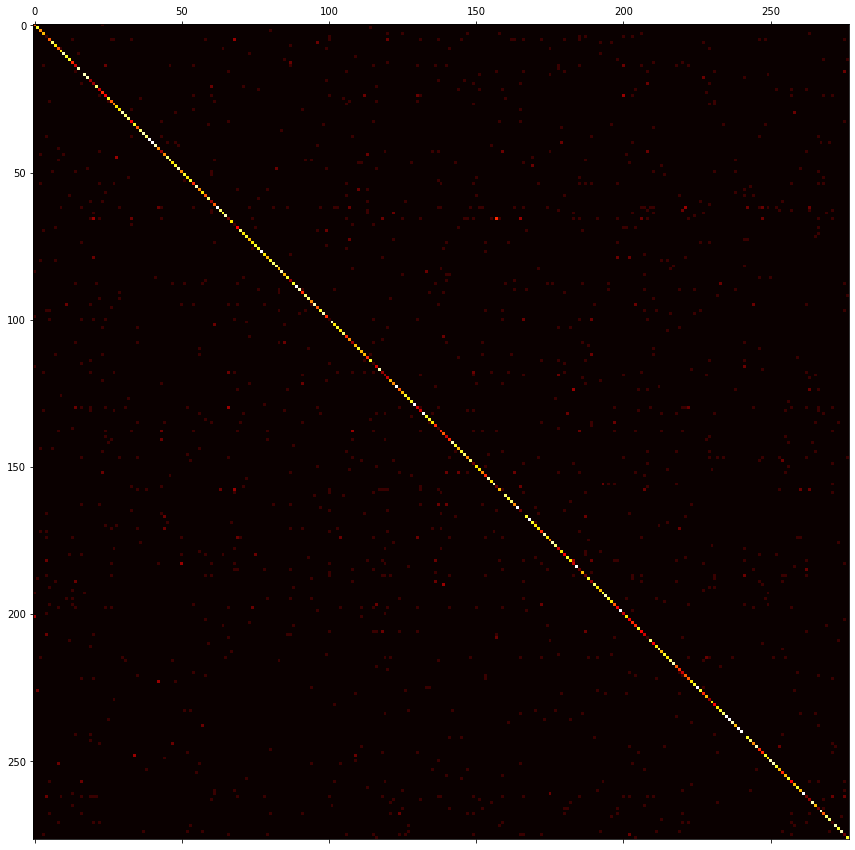

In [41]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

9690

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

5786

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.6261307831481003

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [52]:
xq_test = np.load('pred/feats_test.npy')

In [53]:
xq_test.shape

(39794, 512)

In [54]:
xq_test.max()

73.95083

In [55]:
faiss.normalize_L2(xq_test)

In [56]:
xq_test.max()

0.52683955

In [57]:
D_test, I_test = index.search(xq_test, k) # actual search

In [58]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [59]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 855  591   17  930   45]
 [ 575  575  728  728  929]
 [ 836  994  994   58  288]
 [ 997 1061   37  772  846]
 [ 878  116  985  612  912]]
[[0.82007855 0.39099395 0.34952813 0.3446381  0.2815174 ]
 [0.46738213 0.3977611  0.36511752 0.3509475  0.26827425]
 [0.78211796 0.5727105  0.55985034 0.44275117 0.23786446]
 [0.5896319  0.4346939  0.36409637 0.3035722  0.22063698]
 [0.7150958  0.54462206 0.533062   0.4848157  0.42945004]]


In [60]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[ 215 1053 1053  869  347]
 [ 926  112  316  557  273]
 [ 858  858   76  183  183]
 [ 394  229  229  229  666]
 [ 183  183  858  858  777]]
[[0.32704455 0.27495173 0.2741588  0.24577925 0.21749093]
 [0.74351573 0.5718269  0.41385263 0.4001966  0.37408066]
 [0.5509002  0.5126504  0.43716267 0.36625186 0.3591762 ]
 [0.50568473 0.45405936 0.41995656 0.40578738 0.3164176 ]
 [0.44405815 0.42163396 0.41995963 0.37782866 0.35436594]]


In [61]:
I_test[2]

array([836, 994, 994,  58, 288])

In [62]:
np.unique(I_test[2], return_counts=True)

(array([ 58, 288, 836, 994]), array([1, 1, 1, 2]))

In [63]:
np.save('pred/preds_test_full_k-means.npy', I_test)
np.save('pred/dist_test_full_k-means.npy', D_test)

In [64]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [65]:
np.save('pred/preds_test_k-means.npy', preds_test)
np.save('pred/dist_test_k-means.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)